# DIRECT FEEDBACK ALIGNMENT ON MNIST

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
np.random.seed(1234)
%matplotlib inline

2024-11-21 10:48:06.002172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 10:48:06.002810: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 10:48:06.006581: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 10:48:06.016219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 10:48:06.035618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## CREATING DATASET

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train /= 255.0
X_test /= 255.0


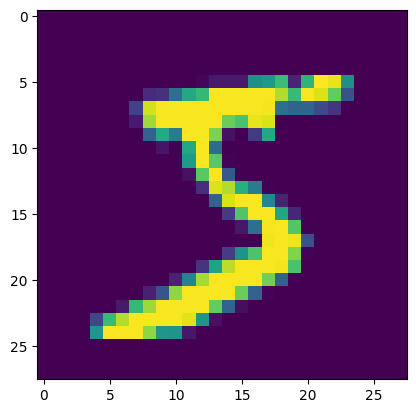

In [3]:
plt.imshow(X_train[0])

In [4]:
print('Input dimensions')
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)

print('After reshaping:', X_train.shape, X_test.shape)


Input dimensions
(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)
After reshaping: (60000, 784) (10000, 784)


In [5]:
print( 'Sample of label:'), y_train[0]

Sample of label:


(None, 5)

In [6]:
# Pass from numerical to classification array (omg it's smart)
nb_classes = 10
y_train = np.eye(nb_classes)[y_train]
y_test = np.eye(nb_classes)[y_test]

In [7]:
print( 'After conversion to categorical:', y_train[0])

After conversion to categorical: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## DEFINITION OF FORWARD AND BACKWARD PASS

In [8]:
import torch
import torch.nn.functional as F


In [9]:
def forward_pass(W1, W2, b1, b2, x):
    '''This is the forward pass. It is equal for any
    training algorithm. It's just one hidden layer
    with tanh activation function and sigmoid on the
    output layer'''
    # if the input is a batch, I have to tile as many
    # b1 and b2 as the batch size
    a1 = np.matmul(W1, x) + np.tile(b1, (x.shape[1], 1))
    h1 = np.tanh(a1)
    a2 = np.matmul(W2, h1) + np.tile(b2, (x.shape[1], 1))
    y_hat = expit(a2)
    return a1, h1, a2, y_hat


In [10]:
def dfa_backward_pass(e, h1, B1, a1, x):
    dW2 = -np.matmul(e, np.transpose(h1))
    da1 = np.matmul(B1, e) * (1 - np.tanh(a1) ** 2)
    dW1 = -np.matmul(da1, np.transpose(x))
    db1 = -np.sum(da1, axis=1, keepdims=True)
    db2 = -np.sum(e, axis=1, keepdims=True)
    return dW1, dW2, db1, db2


## DEFINITION OF FUNCTION TO COMPUTE ANGLE BETWEEN UPDATES

In [11]:
def average_angle(W2, B1, error, a1, a2):
    dh1 = np.mean(np.matmul(B1, error), axis=1, keepdims=True)  # Maybe no derivative needed here
    c1 = np.mean(np.matmul(np.transpose(W2), error * (expit(a2) * (1 - expit(a2)))), axis=1, keepdims=True)
    dh1_norm = np.linalg.norm(dh1)
    c1_norm = np.linalg.norm(c1)
    inverse_dh1_norm = np.power(dh1_norm, -1)
    inverse_c1_norm = np.power(c1_norm, -1)
    
    # ALIGNMENT CRITERION AND ANGLE
    Lk = (np.matmul(np.transpose(dh1), c1) * inverse_dh1_norm)[0, 0]
    beta = np.arccos(np.clip(Lk * inverse_c1_norm, -1., 1.)) * 180 / np.pi
    return Lk, beta


In [12]:
def train(x, y, n_epochs=10, lr=1e-3, batch_size=200, tol=1e-1):
    x = np.transpose(x)
    y = np.transpose(y)
    
    W1, W2 = np.random.randn(800, 784), np.random.randn(10, 800)
    b1, b2 = np.random.randn(800, 1), np.random.randn(10, 1)
    
    dataset_size = x.shape[1]
    n_batches = dataset_size // batch_size
    te_bp = []
    for i in range(n_epochs):
        perm = np.random.permutation(x.shape[1])
        x = x[:, perm]
        y = y[:, perm]
        loss = 0.
        train_error = 0.
        for j in range(n_batches):
            samples = x[:, j * batch_size:(j + 1) * batch_size]
            targets = y[:, j * batch_size:(j + 1) * batch_size]
            a1, h1, a2, y_hat = forward_pass(W1, W2, b1, b2, samples)
            error = y_hat - targets
            preds = np.argmax(y_hat, axis=0) 
            truth = np.argmax(targets, axis=0)
            train_error += np.sum(preds != truth)
            loss_on_batch = F.binary_cross_entropy(targets, y_hat)
            
            dW1, dW2, db1, db2 = dfa_backward_pass(error, h1, W2, a1, samples)
            W1 += lr * dW1
            W2 += lr * dW2
            b1 += lr * db1
            b2 += lr * db2
            loss += loss_on_batch
        training_error = 1. * train_error / x.shape[1]
        print('Loss at epoch', i + 1, ':', loss / x.shape[1])
        print('Training error:', training_error)
        prev_training_error = 0 if i == 0 else te_bp[-1]
        if np.abs(training_error - prev_training_error) <= tol:
            te_bp.append(training_error)
            break
        te_bp.append(training_error)
    return W1, W2, b1, b2, te_bp


In [13]:
W1, W2, b1, b2, te_bp = train(X_train, y_train, n_epochs=100, lr=1e-4, batch_size=200, tol=1e-4)

ValueError: operands could not be broadcast together with shapes (800,200) (160000,1) 

In [93]:
def dfa_train(x, y, n_epochs=10, lr=1e-3, batch_size=200, tol=1e-3):
    x = np.transpose(x)
    y = np.transpose(y)
    
    W1, W2 = np.random.randn(800, 784), np.random.randn(10, 800)
    b1, b2 = np.random.randn(800, 1), np.random.randn(10, 1)
    
    B1 = np.random.randn(800, 10)
    dataset_size = x.shape[1]
    n_batches = dataset_size//batch_size
    te_dfa = []
    angles = []
    for i in xrange(n_epochs):
        perm = np.random.permutation(x.shape[1])
        x = x[:, perm]
        y = y[:, perm]
        loss = 0.
        train_error = 0.
        for j in xrange(n_batches):
            samples = x[:, j*batch_size:(j+1)*batch_size]
            targets = y[:, j*batch_size:(j+1)*batch_size]
            a1, h1, a2, y_hat = forward_pass(W1, W2, b1, b2, samples)
            error = y_hat - targets
            preds = np.argmax(y_hat, axis=0) 
            truth = np.argmax(targets, axis=0)
            train_error += 1.*np.sum(preds!=truth)
            loss_on_batch = log_loss(targets, y_hat)
            
            dW1, dW2, db1, db2 = dfa_backward_pass(error, h1, B1, a1, samples)
            W1 += lr*dW1
            W2 += lr*dW2
            b1 += lr*db1
            b2 += lr*db2
            loss += loss_on_batch
            if j%100==0:
                angles.append(average_angle(W2, B1, error, a1, a2))
        training_error = 1.*train_error/x.shape[1]
        print 'Loss at epoch', i+1, ':', loss/x.shape[1]
        print 'Training error:', training_error
        prev_training_error = 0 if i==0 else te_dfa[-1]
        if np.abs(training_error-prev_training_error) <= tol:
            te_dfa.append(training_error)
            break
        te_dfa.append(training_error)
    return W1, W2, b1, b2, te_dfa, angles

In [94]:
W1dfa, W2dfa, b1dfa, b2dfa, te_dfa, angles = dfa_train(X_train, y_train, n_epochs=100, lr=1e-4, batch_size=200, tol=1e-4)

Loss at epoch 1 : 1.65109241641
Training error: 0.693116666667
Loss at epoch 2 : 1.04916236747
Training error: 0.440316666667
Loss at epoch 3 : 0.873364388419
Training error: 0.3418
Loss at epoch 4 : 0.786652815664
Training error: 0.290133333333
Loss at epoch 5 : 0.731399922834
Training error: 0.257216666667
Loss at epoch 6 : 0.693713566774
Training error: 0.2339
Loss at epoch 7 : 0.664215693563
Training error: 0.217483333333
Loss at epoch 8 : 0.640423813291
Training error: 0.204716666667
Loss at epoch 9 : 0.621577126417
Training error: 0.194166666667
Loss at epoch 10 : 0.605224562283
Training error: 0.184833333333
Loss at epoch 11 : 0.590777934056
Training error: 0.177683333333
Loss at epoch 12 : 0.578247863077
Training error: 0.1709
Loss at epoch 13 : 0.566848705067
Training error: 0.164683333333
Loss at epoch 14 : 0.5567539817
Training error: 0.159583333333
Loss at epoch 15 : 0.547760235865
Training error: 0.154516666667
Loss at epoch 16 : 0.539087800527
Training error: 0.1498166666

In [95]:
def test(W1, W2, b1, b2, test_samples, test_targets):
    test_samples = np.transpose(test_samples)
    test_targets = np.transpose(test_targets)
    outs = forward_pass(W1, W2, b1, b2, test_samples)[-1]
    preds = np.argmax(outs, axis=0) 
    truth = np.argmax(test_targets, axis=0)
    test_error = 1.*np.sum(preds!=truth)/preds.shape[0]
    return test_error

In [97]:
print 'BP:', test(W1, W2, b1, b2, X_test, y_test)*100, '%'
print 'DFA:', test(W1dfa, W2dfa, b1dfa, b2dfa, X_test, y_test)*100, '%'

BP: 7.71 %
DFA: 7.7 %


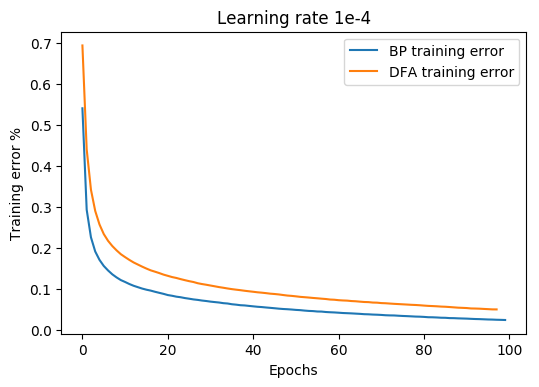

In [98]:
plt.plot(range(len(te_bp)), te_bp, label='BP training error')
plt.plot(range(len(te_dfa)), te_dfa, label='DFA training error')
plt.title('Learning rate 1e-4')
plt.xlabel('Epochs')
plt.ylabel('Training error %')
plt.legend(loc='best')
plt.show()

In [105]:
l, beta = zip(*angles)

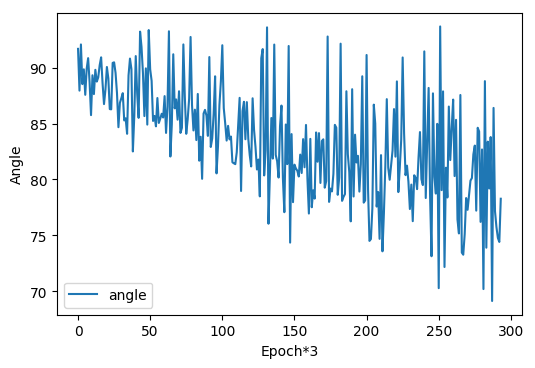

In [108]:
plt.plot(range(len(beta)), beta, label='angle')
plt.legend(loc='best')
plt.xlabel('Epoch*3')
plt.ylabel('Angle')
plt.show()